**The laning phase** is insanely complex, imo under only teamfighting when it comes to skill ceiling

> How is it that even among pros we can see consistent mid gaps?

image.png

*How does Chovy have higher CS in this matchup? Sylas vs Pantheon (KR Challenger)*

**INTUITION:** Naturally, since league is a PvP game it would make sense that we can maybe use some game theory to develop an intuition behind how we should act. Although the actual game is far more complex than this brief introduction will model, im hoping it will atleast help allow some understanding behind how we *should* play


*   We can think of waves as a **repeated game**, i.e. each time our waves meet, it's like a turn for each player
*   Then, at each turn, what should we do? Shove? Slow-push? Freeze?

**ASSUMPTIONS:** For now, we just want to look at the macro-decisions we can make:

1.   We will ignore the *micro* behind trading. So let's assume both players are equally skilled, and act appropriately enough to where this is not a factor.

2.   Sophistications that are kinda champion specific, e.g. item spikes, level-up timers, so on and so forth are too difficult to model and unnecessary for our purposes
<br>
<br>

# **MODEL:** We model laning as a **repeated 2-player game** played over discrete turns (waves)

$$
t = 0,1,\dots,T-1.
$$

Each turn, both players choose an action simultaneously. The lane state updates, and each player receives a reward.

---

## 1) State Variables

At turn \(t\), the lane state (from **your perspective**) is:
$$
s_t = (w_t,\; m_t,\; m^{opp}_t,\; v_t,\; v^{opp}_t,\; g_t)
$$

where:

- $w_t \in \{-2,-1,0,1,2\}$: **wave position**  
  (negative = closer to you, positive = closer to enemy)

- $m_t \in \{0,1,2\}$: **your wave stack size**  
  (0 = normal wave, 2 = large stacked wave)

- $m^{opp}_t \in \{0,1,2\}$: **opponent wave stack size**

- $v_t \in \{0,1\}$: **your vision indicator**  
  (\(v_t = 1\) = you have vision / covered, \(v_t = 0\) = no vision)

- $v^{opp}_t \in \{0,1\}$: **opponent vision indicator**

- $g_t \in [-G, G]$: **gold-difference ** clipped to a range G (for simplicity purposes, + means you are ahead)



### 1.1) Opponent perspective (same underlying lane)

The opponent observes the same lane but from the opposite side:
$$
s^{opp}_t = (-w_t,\; m^{opp}_t,\; m_t,\; v^{opp}_t,\; v_t,\; -g_t).
$$

This “mirroring” keeps the model symmetric

## 2) **Actions**

Action set:

$$
\mathcal{A}=\{\text{SP},\text{SH},\text{F}\}
$$

- $\text{SP}$: slow-push (build a stacked wave)  
- $\text{SH}$: shove (fast push / crash now)  
- $\text{F}$: freeze (hold wave on your side; deny/safe)

Let your action be $a_t$, and the opponent's action be $b_t$.

---

## 3) **Vision Update** (Random)

Vision refreshes each turn as a Bernoulli random variable:

$$
v_{t+1} \sim \mathrm{Bernoulli}(p_v)
$$

so $\Pr(v_{t+1}=1)=p_v$.

---

## 4) **Transition Model**

### 4.1 *Action pressure*

Define lane pressure:

$$
\Delta w(x)=
\begin{cases}
+1 & x=\text{SP}\\
+2 & x=\text{SH}\\
-1 & x=\text{F}
\end{cases}
$$

### 4.2 *Wave position update*

$$
w_{t+1}=\mathrm{min}\Big({max}(w_t+\Delta w(a_t)-\Delta w(b_t),\,-2),\,2\Big)
$$


### 4.3 *Wave stack update*

$$
m_{t+1}=
\begin{cases}
\min(2,\;m_t+1) & a_t=\text{SP}\ \text{and}\ w_{t+1}<2\\[4pt]
0 & a_t=\text{SH}\ \text{and}\ w_{t+1}=2\\[4pt]
\max(0,\;m_t-1) & a_t=\text{F}\\[4pt]
m_t & \text{otherwise}
\end{cases}
$$

Interpretation:

- $\text{SP}$ Tries to stack your wave over time
- $\text{SH}$ Tries to crash the wave  
- $\text{F}$  Tries to freeze

---

## 5) **Interaction Payoff** $M[a,b]$

We include a small "denial" payoff based on the action matchup (rock-paper-scissors style). E.g. if we freeze when our opponent shoves, we are rewarded:

- $\text{SH}$ counters $\text{SP}$  
- $\text{F}$ counters $\text{SH}$  
- $\text{SP}$ counters $\text{F}$  

For a constant $\epsilon>0$ (e.g., $\epsilon=0.3$).

$$
M[a,b]=
\begin{cases}
+\epsilon & a \text{ counters } b\\
-\epsilon & b \text{ counters } a\\
0 & a=b
\end{cases}
$$

Payoff table (to the row player):

$$
\begin{array}{c|ccc}
M[a,b] & b=\text{SP} & b=\text{SH} & b=\text{F}\\ \hline
a=\text{SP} & 0 & -\epsilon & +\epsilon\\
a=\text{SH} & +\epsilon & 0 & -\epsilon\\
a=\text{F}  & -\epsilon & +\epsilon & 0
\end{array}
$$

---

## 6) **Reward Function**

Per-turn reward to you. Note the use of indicator functions, (e.g. 1 *[condition]).

$$
r(s_t,a_t,b_t)=M[a_t,b_t] + B_{\text{plates}} + B_{\text{deny}} + B_{\text{crash}} - L\cdot \text{gank}_t
$$

### * 6.1 Plates / pressure bonus (shove on enemy side)*

$$
B_{\text{plates}}=\beta_{\text{plates}}\;\mathbf{1}[a_t=\text{SH}]\mathbf{1}[w_t\ge 1]
$$


### * 6.2 Deny / safety bonus (freeze on your side)*

$$
B_{\text{deny}}=
\beta_{\text{deny}}\mathbf{1}[a_t=\text{F}]\mathbf{1}[w_t\le -1]
+
\beta_{\text{deny,bonus}}\mathbf{1}[a_t=\text{F}]\mathbf{1}[w_t\le -1]\mathbf{1}[b_t\in\{\text{SP},\text{SH}\}]
$$

Explanation: We have two terms which may be a unintuitive at first glance. One rewards having the wave on our side since this is safer/more dangerous for the enemy, the second is to encourage this behavior even more in the case that the enemy wants to crash it (e.g. they want to move to a play)

### * 6.3 Crash bonus (convert a slow-push into a crash)*

$$
B_{\text{crash}}=\beta_{\text{crash}}\;\mathbf{1}[w_{t+1}=2]\mathbf{1}[m_t=2]
$$

### * 6.4 Gank penalty (risk when extended with no vision)*

$$
\text{gank}_t \sim \mathrm{Bernoulli}(p_{\text{gank}}(s_t,a_t))
$$

$$
p_{\text{gank}}(s_t,a_t)=(1-v_t)\cdot \mathrm{min}\Big({max}(q_0 + q_1\mathbf{1}[w_t=2] + q_2\mathbf{1}[a_t=\text{SH}],\,0),\,1\Big)
$$


Explanation: We want a way to punish "reckless" gameplay, so this is just a term that says if you get ganked in a bad spot (e.g. trying to shove on their side) there is a penalty.

---

## 7) *Gold-Difference Update*

Let $g_t$ track gold difference. Update using both players' rewards:

$$
g_{t+1}=g_t + \big(r_t - r^{\text{'}}_t\big).
$$

---

## 8) * Objective*

A policy $\pi$ maps states to actions (deterministic or probabilistic):

$$
\pi(a\mid s)=\Pr(a_t=a\mid s_t=s).
$$

Each player aims to maximize expected discounted return over $T$ turns:

$$
\max_\pi \mathbb{E}\left[\sum_{t=0}^{T-1}\gamma^t \, r(s_t,a_t,b_t)\right],
\qquad 0<\gamma\le 1.
$$

The expectation is taken over randomness in the environment (vision and gank events) and the opponent's behavior.









**Reinforcement-Learning Set-Up :**
We can now use some RL techniques to try and derive some (hopefully) interpretable results. We will use a style reflective of reality (or atleast my interpretation of such), being a **two-agent** set-up, where we train each side against a *frozen* version of the other for a set-period, before switching and training the other. I think this makes sense; in a real-game, players don't immediately adjust.

We will use a **Q-learning** approach since this is more my style of coaching (i.e. we want to view the game such that we will act optimally in future plays, since this is what we should strive for). Networks like DQN are definitely overkill for our purposes, although maybe this could be useful if the model were to be extended to incorporate *micro* details.

**Other Details:** Features not immediately intuitive of the model will be discussed here :


*   *Policies:* These are all deterministic, and we initially have three (e.g. always shove). After n episodes, we take a snapshot and introduce this as a new policy that may be picked along with the intial three. These snapshots can be thought of as new "strategies" learned in our case through Q-values at time equal to that nth episode (e.g. instead of just always shove, maybe we should only shove if we have vision, otherwise slow push).

**The following diagram outlines the general flow:**

In [ ]:
                ┌──────────────┐
                │  train.py     │
                │ (main loop)   │
                └──────┬───────┘
                       │ creates
        ┌──────────────┼────────────────┐
        │              │                │
        ▼              ▼                ▼
   ┌────────┐     ┌──────────┐     ┌──────────┐
   │ env.py │     │ agents.py│     │policies.py│
   │ LaneEnv│     │ QAgent   │     │ baselines │
   └───┬────┘     └────┬─────┘     └────┬──────┘
       │               │                │
       │ reset/step    │ act/update     │ choose b_t
       │               │                │
       └───────┬───────┴───────┬────────┘
               │               │
               ▼               ▼
            (episode simulation + learning)
               │
               │ calls every N episodes
               ▼
          ┌──────────┐
          │ eval.py   │
          │ evaluate  │
          └────┬──────┘
               │ 
               ▼
          print metrics for avg return, wr, action frequency 


IndentationError: unindent does not match any outer indentation level (<string>, line 6)

Essentially for each training episode:
1) Reset the environment and obtain two observations: obs_y (your perspective) and obs_o (opponent perspective).
2) Sample one opponent policy from policies.py (one of the baselines or a snapshot we took).
3) Repeat until done:

   1. Choose your action a_y using ε-greedy from Q(obs_y, ·).
   2. Opponent chooses action a_o from its (fixed) policy using obs_o.
   3. Step the environment: (obs_y', obs_o'), (r_y, r_o), done = env.step(a_y, a_o).
   4. Update Q-learning agent using (obs_y, a_y, r_y, obs_y').
   5. Set obs_y ← obs_y', obs_o ← obs_o'.
4) Periodically (every N episodes), evaluate the current greedy policy (ε=0) against baseline opponents.
5) Optionally, periodically snapshot the current greedy policy and add it to the opponent pool.

In [32]:
#imports 
from src.env import LaneEnv, LaneParams, SP, SH, F
from src.agents import QLearningAgent
from src.policies import always_shove, freeze_if_possible, stack_then_crash, random_mixed
from src.eval import evaluate
from src.train import train_with_opponent_pool
from collections import defaultdict, Counter
import pandas as pd
import matplotlib.pyplot as plt

# initialize environment and agent
env = LaneEnv(LaneParams())
agent = QLearningAgent()

In [33]:
# train
env = LaneEnv(LaneParams())
agent = QLearningAgent(alpha=0.15, gamma=0.95, eps=0.15)

pool = [always_shove, freeze_if_possible, stack_then_crash]
log = train_with_opponent_pool(env, agent, pool, episodes=1000, snapshot_every=50, eval_every=100, eval_games=20)

agent.eps = 0.0  # greedy for evaluation

[ep 100] avg_return: {'always_shove': 10.775, 'freeze_if_possible': 11.48, 'stack_then_crash': 11.295}
[ep 200] avg_return: {'always_shove': 18.495, 'freeze_if_possible': 18.1, 'stack_then_crash': 16.06}
[ep 300] avg_return: {'always_shove': 25.575, 'freeze_if_possible': 25.785, 'stack_then_crash': 22.275}
[ep 400] avg_return: {'always_shove': 24.86, 'freeze_if_possible': 29.425, 'stack_then_crash': 27.87}
[ep 500] avg_return: {'always_shove': 26.48, 'freeze_if_possible': 27.665, 'stack_then_crash': 27.505}
[ep 600] avg_return: {'always_shove': 27.4, 'freeze_if_possible': 25.855, 'stack_then_crash': 28.825}
[ep 700] avg_return: {'always_shove': 28.705, 'freeze_if_possible': 26.81, 'stack_then_crash': 23.885}
[ep 800] avg_return: {'always_shove': 27.855, 'freeze_if_possible': 26.935, 'stack_then_crash': 26.45}
[ep 900] avg_return: {'always_shove': 28.27, 'freeze_if_possible': 28.59, 'stack_then_crash': 24.98}
[ep 1000] avg_return: {'always_shove': 25.31, 'freeze_if_possible': 27.505, 's

In [30]:
# Policy Map
ACTION_NAME = {0:"SP", 1:"SH", 2:"F"}

old_eps = agent.eps
agent.eps = 0.0

rows = []
for w in [-2,-1,0,1,2]:
    for v_self in [0,1]:
        s = (w, 0, 0, v_self, 1, 0)  # (w, m_self, m_opp, v_self, v_opp, g)
        a = agent.act(s)
        rows.append({"w": w, "v_self": v_self, "action": ACTION_NAME[a]})

agent.eps = old_eps

policy_map = pd.DataFrame(rows).pivot(index="w", columns="v_self", values="action")
policy_map

v_self,0,1
w,,
-2,F,SH
-1,SP,SP
0,F,F
1,SP,SP
2,F,F


This table can be read to see the "best" actions given our vision state. We can see that our agent learns shoving is *bad* if we don't have any, which checks out as we want to be in a "safe" position in this case. 

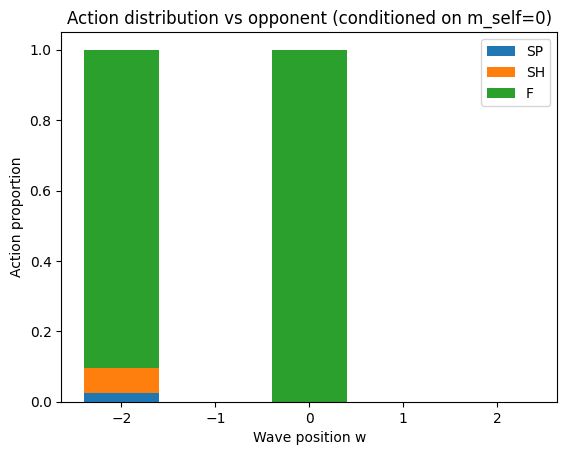

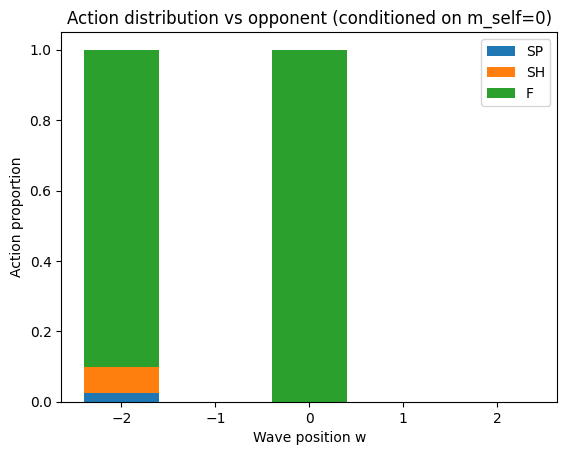

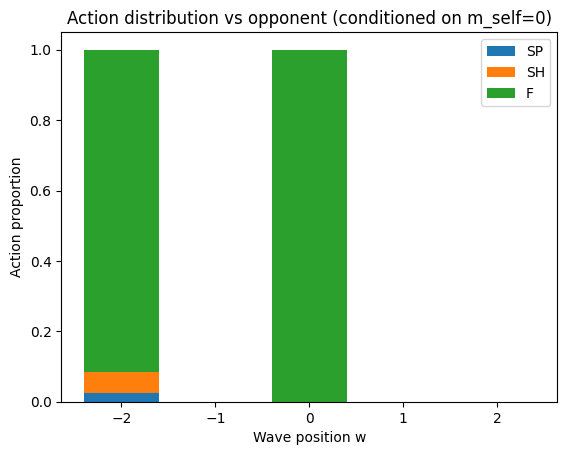

In [42]:
# Plots

# run a counter for an oppponent policgy 
def eval_counts(env, agent, opp_policy, games=1000):
    """
    Returns:
      counts[(w, m_self)] -> Counter({"SP":..., "SH":..., "F":...})
    """
    ACTION_NAME = {0:"SP", 1:"SH", 2:"F"}
    counts = defaultdict(Counter)

    old_eps = agent.eps
    agent.eps = 0.0  # greedy eval

    for _ in range(games):
        obs_y, obs_o = env.reset()
        done = False
        while not done:
            # obs_y = (w, m_self, m_opp, v_self, v_opp, g)
            w, m_self, m_opp, v_self, v_opp, g = obs_y

            a_y = agent.act(obs_y)
            a_o = opp_policy(obs_o)

            counts[(w, m_self)][ACTION_NAME[a_y]] += 1

            (obs_y, obs_o), _, done = env.step(a_y, a_o)

    agent.eps = old_eps
    return counts

# action distribution given a wave position
def plot_w(counts, m_self_fixed):
    ws = [-2, -1, 0, 1, 2]
    actions = ["SP", "SH", "F"]

    # make arrays
    data = {a: [] for a in actions}
    for w in ws:
        c = counts.get((w, m_self_fixed), Counter())
        total = sum(c.values()) or 1
        for a in actions:
            data[a].append(c.get(a, 0) / total)  # proportions

    # stacked bars
    bottom = [0]*len(ws)
    for a in actions:
        plt.bar(ws, data[a], bottom=bottom, label=a)
        bottom = [bottom[i] + data[a][i] for i in range(len(ws))]

    plt.xlabel("Wave position w")
    plt.ylabel("Action proportion")
    plt.title(f"Action distribution vs opponent (conditioned on m_self={m_self_fixed})")
    plt.legend()
    plt.show()

# counts
counts_AS = eval_counts(env, agent, always_shove, games=1000)
counts_F = eval_counts(env, agent, freeze_if_possible, games=1000)
counts_SC = eval_counts(env, agent, stack_then_crash, games=1000)

# plots
plot_w(counts_AS, m_self_fixed=0)
plot_w(counts_F, m_self_fixed=0)
plot_w(counts_SC, m_self_fixed=0)

We can see that no matter the opponent policy (enemy strategy) our agent does the same thing no matter what. In other words, we can see that our model thinks the best strategy is basically to always try and freeze (bring the wave towards us) given the wave is *not stacked*. 

This makes sense given the simplified model. Of course in a real game we may want to do other things like roam/skirmish, but truthfully even in this "model" the output is still intuitive, i.e. bringing the wave to us gives us more *control* and puts the ball in our court where we have more options to do as we wish.

In [44]:
!python -m src.train

[ep 1000] avg_return: {'always_shove': 27.373, 'freeze_if_possible': 27.299, 'stack_then_crash': 26.285}
[ep 2000] avg_return: {'always_shove': 28.018, 'freeze_if_possible': 27.248, 'stack_then_crash': 27.782}
[ep 3000] avg_return: {'always_shove': 21.353, 'freeze_if_possible': 22.543, 'stack_then_crash': 21.832}
[ep 4000] avg_return: {'always_shove': 27.672, 'freeze_if_possible': 27.821, 'stack_then_crash': 26.267}
[ep 5000] avg_return: {'always_shove': 27.545, 'freeze_if_possible': 27.056, 'stack_then_crash': 27.513}

Final evaluation:
always_shove {'avg_return': 27.38659999999996, 'win_rate': 0.884, 'action_freq': {'SP': 239, 'SH': 1411, 'F': 18350}}
freeze_if_possible {'avg_return': 27.28619999999996, 'win_rate': 0.886, 'action_freq': {'SP': 215, 'SH': 1371, 'F': 18414}}
stack_then_crash {'avg_return': 27.40019999999991, 'win_rate': 0.894, 'action_freq': {'SP': 373, 'SH': 1047, 'F': 18580}}


We can see that freezing (F) is very dominant with proportions far exceeding those of slow pushing or shoving. Given our model ignores nuances like roaming/objectives, this makes sense. Purely from a laning standpoint, zero-sum makes sense since denying our opponent is one of the best ways to build advantages for ourselves. 